In [ ]:
%load_ext autoreload
%autoreload 2

from nbdev import *
from fastcore.test import *
from fastai2.vision.all import *
import pandas as pd
from rory.core import *
%nbdev_default_export bboxes

Cells will be exported to rory.bboxes,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Load pickle into df, dfd

In [ ]:
# import pickle from ETL notebook's into df_all
path = Path('/home/rory/data/coco2017')
df_all = pd.read_pickle(path/'data.pkl')

# create dataframe dict dfd
dfd = df_all.set_index('img')
dfd = dfd.to_dict()
print(dfd['lrg']['train2017/000000391895.jpg'])

# create subset of df
subset_fraction = .1

df = pd.DataFrame(df_all[['img', 'lrg', 'lrg_bb', 'lrg_cls', 'is_val']]
                     .sample(frac=subset_fraction)
                     .reset_index()
                     .drop(columns='index')        # note that drop creates a copy, so
                    ).copy()                       # this step is actually reundant.
df.head(1)

[[339.88, 22.16, 493.76, 322.89000000000004], 'person']


,img,lrg,lrg_bb,lrg_cls,is_val
0,train2017/000000057591.jpg,"[[364.77, 95.69, 558.16, 361.85], person]","[364.77, 95.69, 558.16, 361.85]",person,False


New df just for task at hand: `img`, `lrg_bb`, `is_val`, reduced size.

# Largest class classifier

### ETL

In [ ]:
dls = ImageDataLoaders.from_df(df, path=path, bs=64,
                               fn_col='img', label_col='lrg_cls', valid_col='is_val',
                               item_tfms=Resize(128), batch_tfms=aug_transforms(size=128))

dls.show_batch(figsize=(5,5))

### Architecture & LR selection

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

In [ ]:
lr = 1e-2

### Fine tune

In [ ]:
learn.fine_tune(2, lr)

### More fine tuning

In [ ]:
# learn.unfreeze()

# Largest BBox regresser

## ETL

### Examples

#### COCO

Taken from the bottom of this page: https://docs.fast.ai/vision.augment#All-together

(#10) [(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48

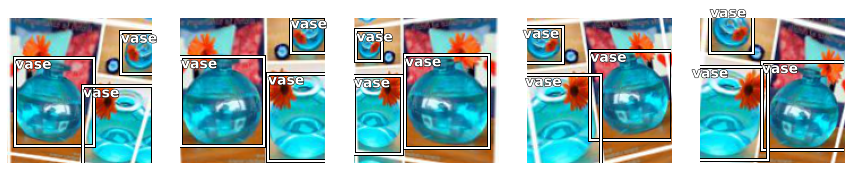

In [ ]:
coco = untar_data(URLs.COCO_TINY)                     # grabbed data
images, lbl_bbox = get_annotations(coco/'train.json') # unpack annotations
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx] # return (path, [bboxs, lbls])

def _coco_bb(x):  return TensorBBox.create(bbox[0])   # return bboxes::T(L(L(floats)) for each img
def _coco_lbl(x): return bbox[1]                      # return labels::L(strs) for each img

coco_dsrc = Datasets([coco_fn]*10,       # src::list
                     [PILImage.create,   # [img, bbs, labels]
                      [_coco_bb],
                      [_coco_lbl, MultiCategorize(add_na=True)]],
                     n_inp=1)

coco_tdl = TfmdDL(coco_dsrc, bs=8,
                  after_item=[BBoxLabeler(), PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

print(coco_dsrc)
coco_tdl.show_batch(nrows=1,ncols=5)

#### COCO w/o labels

(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]))


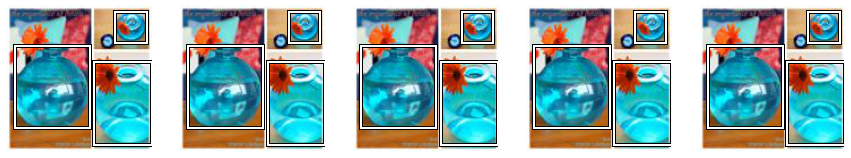

In [ ]:
def coco_bb(x):  return TensorBBox.create(bbox[0])
coco_src = [coco_fn]*10

coco_ds = Datasets(coco_src,
                   [PILImage.create, coco_bb], # transform coco_src into tuple of len 2
                   n_inp=1)

coco_tdl = TfmdDL(coco_dsrc, bs=8,
                  after_item=[PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

print(coco_ds[0])
coco_tdl.show_batch(nrows=1,ncols=5)

#### MNIST

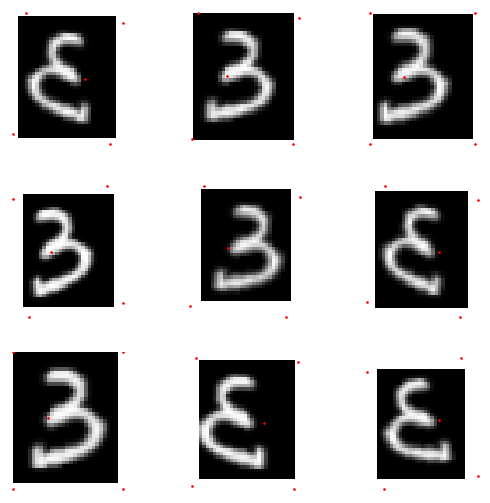

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
mnist_fn = 'train/3/7590.png'
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
def get_mnist_path(fn): return mnist/fn
def _pnt_lbl(fn)->None: return TensorPoint.create(pnts)

pnt_dsrc = Datasets([mnist_fn]*10,
                    [[get_mnist_path, PILImage.create, Resize((35,28))],
                     _pnt_lbl])

pnt_tdl = TfmdDL(pnt_dsrc.train, bs=9,
                 after_item=[PointScaler(), ToTensor()],
                 after_batch=[IntToFloatTensor(), *aug_transforms(max_warp=0)])

pnt_tdl.show_batch(max_n=9)

### My work

#### Using DataBlocks API

PILImage mode=RGB size=612x612
TensorBBox([[155.7600,   0.6900, 612.0000, 605.8000]])
TensorMultiCategory([1])


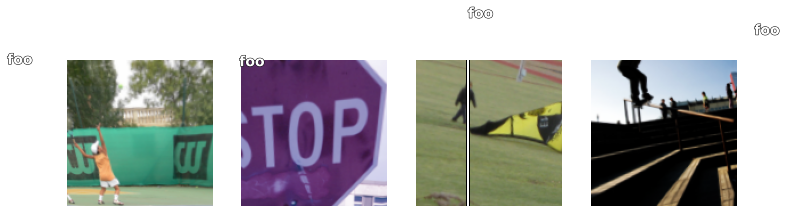

In [ ]:
def get_img(df): return PILImage.create(path/df['img'])
def get_bb(df): return TensorBBox.create(bb_df['lrg_bb'][0])
def get_lbl(df): return ['foo']
def splitter(df):
    train = df.index[~df['is_val']].tolist()
    valid = df.index[df['is_val']].tolist()
    return train,valid

db = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    splitter=splitter,
    get_x=get_img,
    get_y=[get_bb, get_lbl],
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(),
    n_inp=1)

ds = db.datasets(bb_df)
im,bb,lbl = ds.train[0]
print(im,bb,lbl,sep='\n')
# print(len(ds.valid), len(ds.train))
# ctx=im.show()
# bb.show(ctx=ctx)

dl = db.dataloaders(bb_df)
dl.show_batch(nrows=1, ncols=4)

#### Without DataBlock API

In [ ]:
src[0:3]

['train2017/000000057591.jpg',
 'train2017/000000027569.jpg',
 'train2017/000000116696.jpg']

In [ ]:
def get_path(f): return path/f
def get_bb(f): return dfd['lrg_bb'][f]

src = df['img'].tolist()

ds = Datasets(src,
              [[get_path, PILImage.create],
               [get_bb, TensorBBox.create]],
              n_inp=1)
ds.train[0]

(PILImage mode=RGB size=640x427,
 TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]]))

In [ ]:
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb * tensor(s/w,s/h,s/w,s/h)

ds_sq = list(map(squish_imbb, ds)); ds_sq[0:5]

[(PILImage mode=RGB size=128x128,
  TensorBBox([[ 72.9540,  28.6846, 111.6320, 108.4703]])),
 (PILImage mode=RGB size=128x128,
  TensorBBox([[ 25.8420,  27.2320,  47.2960, 121.7173]])),
 (PILImage mode=RGB size=128x128,
  TensorBBox([[  0.4160,  55.0060, 128.0000, 128.0000]])),
 (PILImage mode=RGB size=128x128,
  TensorBBox([[  3.0700,   1.3849, 128.0000, 126.7949]])),
 (PILImage mode=RGB size=128x128,
  TensorBBox([[  5.7440,  34.5179, 121.9600, 100.6753]]))]

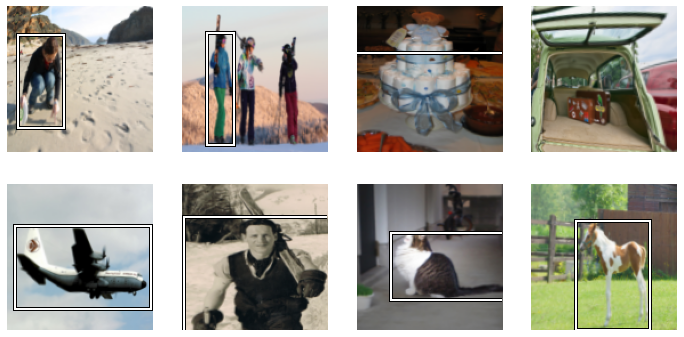

In [ ]:
dl = TfmdDL(ds_sq, bs=8,
            after_item=[PointScaler(), ToTensor()],
            after_batch=[IntToFloatTensor(), *aug_transforms()])

dl.show_batch(max_n=8)

# Chalk board

What I'm working with:

(PILImage mode=RGB size=640x427, TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]]))


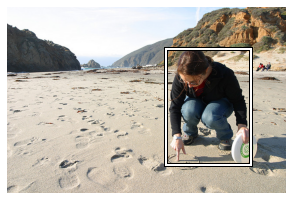

In [ ]:
imbb = ds.train[0]
print(imbb)
type(imbb)

def show_imbb(imbb): imbb_ctx = imbb[0].show(); imbb[1].show(ctx=imbb_ctx)
show_imbb(imbb)

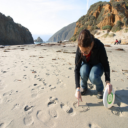

In [ ]:
scale_im = Resize(128, ResizeMethod.Squish)
imr = scale_im(im)
imr

In [ ]:
bb

TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]])

In [ ]:
bb[0]

tensor([364.7700,  95.6900, 558.1600, 361.8500])

In [ ]:
bb[0][0]

tensor(364.7700)

In [ ]:
bb[0][0],bb[0][1],bb[0][2],bb[0][3]

(tensor(364.7700), tensor(95.6900), tensor(558.1600), tensor(361.8500))

In [ ]:
bbx = TensorBBox([bb[0][0],bb[0][1],bb[0][2],bb[0][3]]); bbx

TensorBBox([364.7700,  95.6900, 558.1600, 361.8500])

TensorBBox([ 72.9540,  28.6846, 111.6320, 108.4703])


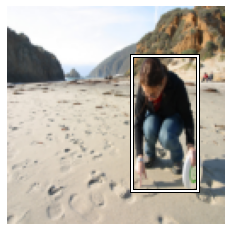

In [ ]:
s = 128
w,h = im.size
sw,sh = s/w, s/h
bbr = TensorBBox([sw*bb[0][0],
                  sh*bb[0][1],
                  sw*bb[0][2],
                  sh*bb[0][3]])
print(bbr)
ctx = imr.show(); bbr.show(ctx=ctx)

In [ ]:
squish_im = Resize(128, ResizeMethod.Squish)

In [ ]:
l = tensor(1,2,3)
m = tensor([2],[2],[2])
n = tensor(2,2,2)
nn = tensor(1,2,3)
l*m
l*nn

bbx = TensorBBox([[1,2,3,4]])
bbx * tensor(1,2,1,2)

TensorBBox([[1, 4, 3, 8]])

In [ ]:
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb * tensor(s/w,s/h,s/w,s/h)

(PILImage mode=RGB size=640x427, TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]]))
(PILImage mode=RGB size=128x128, TensorBBox([[ 72.9540,  28.6846, 111.6320, 108.4703]]))


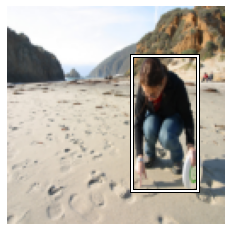

In [ ]:
imbbr = squish_imbb(imbb)
print(imbb)
print(imbbr)
ctx = imbbr[0].show(); imbbr[1].show(ctx=ctx)

In [ ]:
ds[1]

(PILImage mode=RGB size=640x360,
 TensorBBox([[129.2100,  76.5900, 236.4800, 342.3300]]))

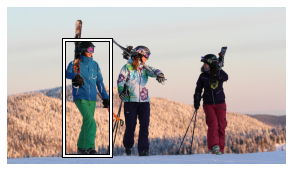

In [ ]:

show_imbb(ds[1])

# Abandoned Scratch

In [ ]:
###
###
### Other

In [ ]:
class ResizeBBox(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, bb: PILImage):
        aug_img = self.aug(image=np.array(b))['image']
        return PILImage.create(aug_img)

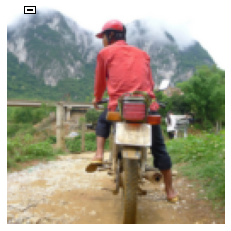

In [ ]:
ctx = imr.show()
bboxrr.show(ctx=ctx)

In [ ]:
r=Resize(128)
r

Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection'}:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(Image,object) -> encodes
decodes: 

Pipeline: (Image, Bbox, Label)
1. Bbox to Point
2. PointScaler
3. Resize Img
4. Resize Point
5. Point to BBox

In [ ]:
def bbox2pt(ibl):
    i,b,l = ibl
    return i, TensorPoint.create(b), l

def pt2bbox(ibl):
    i,b,l = ibl
    return i, TensorBBox([[*b[0],*b[1]]]), l

def resize_bbox(ibl):
    i,b,l = ibl
    return i, aug(b,im.size), l

ibl = im,bbox,'foo'
ipl = bbox2pt(ibl)
iblr = pt2bbox(ipl)
test_eq(ibl, iblr)

In [ ]:
Bbox2pt = Transform(bbox2pt)
Pt2bbox = Transform(pt2bbox)
Resize_bbox = Transform(resize_bbox)

In [ ]:
trans = Pipeline([Bbox2pt, PointScaler(), Resize(128), Pt2bbox, Resize_bbox])